# Lecture 5: perspectives

## Content

* summary of lecture 4
* `scipy`:
    * optimisation
    * distributions
* read/write files
* speeeeeeeed with `numba`
* what more?

## Summary of lecture 4

* plotting with `matplotlib`
* data science: `pandas`
    * the `DataFrame`
    * loading data
    * standard operations

In [1]:
#

## Numerical Programming with `scipy`


Let's just cover some simple examples.

### Statistics and distributions

Let's use ``scipy.stats`` to generate some data from the Beta distribution

In [49]:
#

Now let's histogram it and compare it to the original density

In [50]:
#

Other methods of the distribution `q`

In [51]:
#

### Roots and fixed points

Let's choose an arbitrary function to work with

In [52]:
#

Here we see that the algorithm gets it wrong --- ``newton`` is fast but not robust

Let's try a hybrid method

In [53]:
#

Note that the hybrid method is robust but still quite fast...

### Numerical optimization

In [54]:
#

## Files i/o

### Read file

Assume we have the following file, located in the same folder as Python:

`myfile.txt`

The `open()` function returns a file object, which has a read() method for reading the content of the file:

In [2]:
#

We can now access the content of the file using the `read()` method:

In [3]:
#

You can return one line by using the readline() method.

Read one line of the file:


In [4]:
#

Read the next line of the file:

In [5]:
#

Loop through the file line by line:

In [6]:
#

It is a good practice to always close the file when you are done with it:

In [7]:
#

### Write a file

First, let's write to an existing file. To write to an existing file, you must add a parameter to the open() function:

    * `a` - Append - will append to the end of the file

    * `w` - Write - will overwrite any existing content

Open the file "myfile.txt" and append content to the file:

In [8]:
#

Open and read the file:

In [9]:
#

Create a New File
To create a new file in Python, use the open() method, with one of the following parameters:

    * `x` - Create - will create a file, returns an error if the file exist

    * `a` - Append - will create a file if the specified file does not exist

    * `w"`- Write - will create a file if the specified file does not exist

Create a file called "anotherfile.txt":


In [10]:
#

Result: a new empty file is created!

Create a new file if it does not exist:



In [11]:
#

## Speed

### `numba`

Numba allows the compilation of selected portions of Python code to native code, using the llvm library as its backend. This allows the selected functions to execute at a speed competitive with code generated by C compilers.

It works at the function level. We can take a function, generate native code for that function as well as the wrapper code needed to call it directly from Python. This compilation is done on-the-fly and in-memory.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
size = 200 # try 400 to make it even nicer
iterations = 50 # or try 100

Lets pick an example function that is expensive to calculate and looks nice. I take the ["Madelbrot set"](https://en.wikipedia.org/wiki/Mandelbrot_set):

In [36]:
def mandelbrot_python(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (-2 + 3. / size * j +
                 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [37]:
m0 = mandelbrot_python(size, iterations)

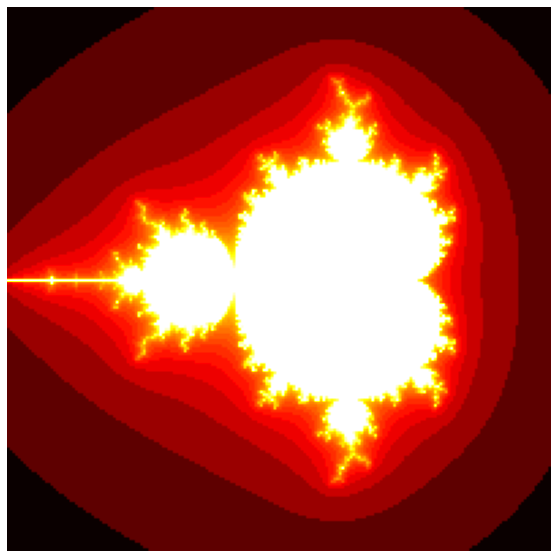

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m0), cmap=plt.cm.hot)
ax.set_axis_off()

In [43]:
%timeit mandelbrot_python(size, iterations)

1.29 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This takes quite a while. Lucky us that we did not use a higher number in `size` and `iteration`. Let's speed this up. The first take is always on `numpy`. Numpy is faster than pure Python because under the hood, its vector structure gets translated to Fortran, which is compiled code. 

Let's give this a go. The next two chuncs of code are a vectorized version of our `mandelbrot` function. You don't need to understand this in detail yet.

In [68]:
## initialize the set of pixels
def initialize(size):
    x, y = np.meshgrid(np.linspace(-2, 1, size),
                       np.linspace(-1.5, 1.5, size))
    c = x + 1j * y
    z = c.copy()
    m = np.zeros((size, size))
    return c, z, m

In [12]:
## function to iterate on the pixel
def mandelbrot_numpy(c, z, m, iterations):
    for n in range(iterations):
        indices = np.abs(z) <= 10
        z[indices] = z[indices] ** 2 + c[indices]
        m[indices] = n

In [70]:
%%timeit -n1 -r10 c, z, m = initialize(size)
mandelbrot_numpy(c, z, m, iterations)

40.8 ms ± 9.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


That is definitely faster. But we had to vectorize our code to gain from the speed advantage of `numpy`. And we can even go beyond this benchmark, by compiling our own code. `numba` does this for us.

In [71]:
from numba import jit

The dark magic lies alone in the small operator `@jit`:

In [72]:
@jit # NOTE: this is the only difference!
def mandelbrot_numba(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (-2 + 3. / size * j +
                 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [73]:
%timeit mandelbrot_numba(size, iterations)

8.13 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using `@jit` does not require any special editions to your function. It discovers automatically which parts of your function can be "jitted" - that means, just-in-time compiled - and what not. We can be even faster if we know that all parts of our function can be jitted by using the numba nopython mode:

In [74]:
from numba import njit

The `@njit` operator just assumes that `numba` can compile your function.

In [75]:
@njit # NOTE: again, this is the only difference to before
def mandelbrot_njit(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (-2 + 3. / size * j +
                 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [65]:
%timeit mandelbrot_njit(size, iterations)

8.26 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
